## Lets try things on Real HSC now ...
Added by Shooby Sep 25 <br>
Last edited Sep 25th

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np

import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image

from peak_finding import (
    PeakFinder,
    find_peaks,
)
%matplotlib inline

In [2]:
def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename,1)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

ngpu,ngf,nc,device = 1,64,1,'cpu'
netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_blended_700.pth',map_location='cpu'))


<All keys matched successfully>

In [3]:
sub =  np.genfromtxt('source-extractor/subaru.cat')
sel = (sub[:,3]<26)
ra, dec = sub[sel,1],sub[sel,2]
print(len(ra))

574


266


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


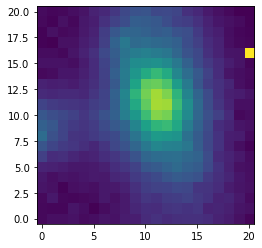

In [7]:
n=np.random.randint(len(ra)-1)
print(n)
data = cut(ra[n],dec[n],11,'source-extractor/cutout-HSC-I-9813-s16a_deep-190924-232349.fits')
khar = data.byteswap().newbyteorder()
im = khar[:-1,:-1]

im = (255.0 / (im.max()+0.5) * (im)).astype(np.uint8)
#### images need to be normalized before seeing GAN#########
# from torchvision import transforms
# transforms.normalize(0.5,0.5)(gals)
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
im = tfms(im)
gals = np.repeat(im[:,:,:,np.newaxis],1,axis = 3)
gals =torch.tensor(gals, device="cpu").float()
gals = gals.permute(3,0,1,2)
plt.imshow(gals[0,0,:,:],origin='lower')

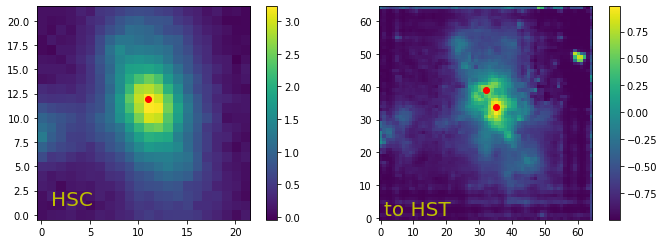

In [8]:
real_cpu = gals.to(device)


psf_hsc = pyfits.getdata('psf-calexp-pdr2_dud-HSC-I-9813-7,5-149.75891-2.45818.fits')
num = find_peaks(image=data, kernel = psf_hsc,thresh=np.std(data)/2)
x,y = [],[]
for boz in range(len(num)):
    if (3<num[boz][0]<18)&(3<num[boz][1]<18):
        x.append(num[boz][0])
        y.append(num[boz][1])

plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.imshow(data,origin='lower')
plt.plot(y,x,'ro')
plt.colorbar()
plt.text(1,1,'HSC',color='y',size=20)


fake = netS(real_cpu)
fd = fake.detach()
psf = pyfits.getdata('psf_i.fits')
new_high = np.array(fd[0,0,:,:])

num = find_peaks(image=new_high, kernel = psf,thresh=np.std(new_high)/2)
x,y = [],[]
for boz in range(len(num)):
    if (10<num[boz][0]<50)&(10<num[boz][1]<50):
        x.append(num[boz][0])
        y.append(num[boz][1])
        
plt.subplot(1,2,2)
plt.imshow(new_high,origin='lower')
plt.plot(y,x,'ro')
plt.colorbar()
plt.text(1,1,'to HST',color='y',size=20)

plt.tight_layout()